In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_rows", 200)
matplotlib.rcParams.update({"axes.spines.right": False, "axes.spines.top": False, "legend.frameon": False})

In [80]:
df = pd.read_json("../out/l40s-py-2026-01-15T16-07-10.jsonl", lines=True).drop(columns=[
    "n", "g", "copies", "inner_reps", "outer_reps",
    "id", "device", "cuda_version", "torch_version", "triton_version", "commit",
])
df["gb_s"] = df["bytes_rw"] / df["avg_time"] / 1e9
df["tflops"] = df["ops"] / df["avg_time"] / 1e12

# Remove "mm" tests where "mv" was also run, for batch size 1
df = df[~((df.m == 1) & df.test.isin(["mm", "mm_ref", "mm_lut8_ref_unscaled", "mm_lut8_ref", "mm_lut8"]))]
df["kernel"] = df.test.apply(dict(
    mm="triton", mv="triton",
    mm_ref="torch", mv_ref="torch",
    mm_lut8_ref_unscaled="torch.compile:unscaled", mv_lut8_ref_unscaled="torch.compile:unscaled",
    mv_lut8_ref="torch.compile", mm_lut8_ref="torch.compile",
    mv_lut8="triton", mm_lut8="triton",
    marlin="marlin",
).__getitem__)
assert df.groupby(["m", "k", "bits", "kernel"]).avg_time.count().max() == 1, "duplicate entries with same kernel name"
df = df.drop(columns=["test"])

df.head()

,m,k,bits,bytes_rw,ops,avg_time,avg_time_stderr,gb_s,tflops,kernel
0,1,8192,16,134250496,134217728,0.000182,2.104755e-08,739.266325,0.739086,torch
1,1,8192,16,134250496,134217728,0.000176,1.953449e-08,764.392714,0.764206,triton
4,1,8192,8,69238784,134217728,0.000091,3.031233e-07,760.667229,1.474535,torch.compile:unscaled
5,1,8192,8,69238784,134217728,0.000283,4.010581e-07,244.474818,0.473909,torch.compile
6,1,8192,8,69238784,134217728,0.000096,2.055862e-08,722.293419,1.400149,triton


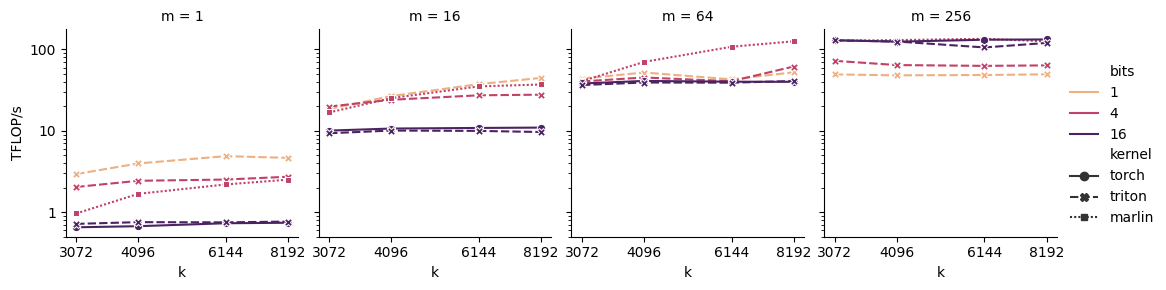

In [78]:
g = sns.relplot(
    data=df[(~df.kernel.isin(["torch.compile", "torch.compile:unscaled"])) & (df.bits.isin([1, 4, 16]))],
    y="tflops", x="k", col="m", style="kernel",
    hue="bits", hue_norm=matplotlib.colors.LogNorm(), palette="flare",
    kind="line", markers=True, height=3, aspect=0.9,
)
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_xticks([3072, 4096, 6144, 8192])
    ax.yaxis.set_major_formatter("{x:.0f}")
g.axes[0, 0].set_ylabel("TFLOP/s");